# Adaptive PDE discretizations on cartesian grids
## Volume : Non-divergence form PDEs
## Part : Eikonal equations
## Chapter : Eulerian schemes

This notebook presents a single pass Eulerian scheme for the Riemannian eikonal equation. It is provided solely for pedagogical purposes.
Indeed, let us emphasize that a state of the art C++ implementation, more optimized and versatile, is also provided. It is strongly recommended to use that implementation for any serious application, see [notebook](../Notebooks_FMM/Riemannian.ipynb) and volume [summary](../Notebooks_FMM/Summary.ipynb). 

The purpose of this notebook is to illustrate the theory and implementation principles underlying eikonal equation solvers, in particular the (anisotropic) fast marching method and the fast sweeping method. 
The PDE to be solved is known as the *Riemannian eikonal equation*, and it involves a Riemannian metric $M : \Omega \to S_d^{++}$ on a domain $\Omega\subset R^d$. Denoting by $u : \Omega \to R^d$ the unkown, the problem is written
$$
    \| \nabla u(x)\|_{D(x)} = 1
$$
for all $x \in \Omega$, where $D(x) := M(x)^{-1}$. Null boundary conditions, or outflow boundary conditions, are applied on $\partial \Omega$. The solution $u$ should be regarded as the arrival times of a front originating from the boundary. Minimal paths toward the boundary, also known as minimal geodesics, can be extracted by solving the ODE
$$
    \gamma'(t) := V(\gamma(t))
$$
where $V(x) := D(x) \nabla u(x)$.

**Important ! Note on computation speed.** Because of intrinsic limitations of the Python programming language, and in particular the slow execution of sequential programs, the fast marching eikonal solver implemented in this notebook is extremely slow. In particular it is slower than the global iteration, or the fast sweeping method, also implemented. The fast marching method is here only implemented for pedagogical purposes. Please use the C++ implementation, or some reimplementation of the Python programs below in a compiled language, for any application.

**Note on accuracy.** The eikonal equation solver presented below is extremely basic, and presented solely for pedagogical purposes. Two optional techniques, implemented in the c++ version allow to increase accuracy: equation factoring, and a dynamic switch to second order finite differences.

**Reference.** The numerical scheme implemented in this notebook is described in the following publication:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019, IPOL [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

[**Summary**](Summary.ipynb) of volume Non-Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. The update operator](#1.-The-update-operator)
  * [2. Iteration policies](#2.-Iteration-policies)
    * [2.1 Global iteration](#2.1-Global-iteration)
    * [2.2 Fast sweeping](#2.2-Fast-sweeping)
    * [2.3 Fast marching](#2.3-Fast-marching)
  * [3. Anisotropic metric](#3.-Anisotropic-metric)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [ ]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; TocTools.displayTOC('EikonalEulerian','NonDiv')

In [3]:
import sys; sys.path.append("..") # Allow import from parent directory
from agd import Selling
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import heapq
import scipy.linalg

In [5]:
def LInfNorm(a):
    return np.max(np.abs(np.array(a)))

def as_field(u,shape):
    ndim = len(shape)
    if u.ndim>=ndim and u.shape[-ndim:]==shape: return u
    else: return np.broadcast_to(u.reshape(u.shape+(1,)*ndim), u.shape+shape)

## 1. The update operator

Our discretization of the eikonal equation is based on a decomposition of the inverse tensors to the Riemannian metric. For all $x \in \Omega$,
$$
    D(x) = \sum_{1 \leq i \leq I} \rho_i(x) e_i e_i^T
$$
where $\rho_i(x) \geq 0$ is a non-negative weight, and $e_i=e_i(x) \in Z^d$ is an offset, which may depend on the current position $x$.
The numerical scheme reads
$$
    F u (x) := \sum_{1 \leq i \leq I} \rho_i(x) \max \{0,\frac{u(x)-u(x-h e_i)} h, \frac{u(x)-u(x+h e_i)} h\}^2 - 1.
$$
for all discretization points $x$ in the domain interior. One has to solve $F u \equiv 0$.

**Historical note.**
This numerical scheme was introduced by Rouy in 1992, in the case of an isotropic metric: $D(x)$ is proportional to the identity matrix. In that special case, the natural tensor decomposition only uses offsets from the canonical basis. It was observed by Sethian in 1996 that it can be solved in a single pass using the fast marching method. 

The author, in 2018, generalized the scheme to handle arbitrary anisotropic Riemannian metrics, using adequate methods for tensor decomposition. See the reference in the introduction.

In [7]:
def Scheme(u,coefs,offsets,h):
    v = np.maximum(0,np.maximum(-fd.DiffUpwind(u, offsets,gridScale=h,padding=np.inf),
                                -fd.DiffUpwind(u,-offsets,gridScale=h,padding=np.inf)))
    residue = (coefs*np.maximum(0,v)**2).sum(axis=0) - 1.
    boundary = np.logical_or.reduce(np.isnan(coefs),axis=0)
    return np.where(boundary,0.,residue)

In contrast with the other notebooks of this series, we will not use a Newton method to solve this numerical scheme. Instead, we rely on Gauss-Siedel updates. In other words we solve, pointwise, for $u(x)$ assuming that $u(y)$ is fixed for all $y \neq x$. These updates are repeated until convergence, following an order in the domain that is discussed below.

**Gauss-Siedel update of $u(x)$.** Consider a fixed point $x \in \Omega$, and denote, for all $1 \leq i \leq I$,
$$
    v_i := \min \{u(x-h e_i), u(x+h e_i)\}.
$$
Assume that $v_1 \leq \cdots \leq v_I$, up to sorting these quantities.
Then $\lambda = u(x)$ is the solution to a quadratic equation
$$
    \alpha \lambda^2 - 2 \beta \lambda + \gamma = 0
$$
where 
$$
    \alpha := \sum_{1 \leq i \leq J} \rho_i, \quad \beta := \sum_{1 \leq i \leq J} \rho_i v_i, \quad \gamma := -h^2+\sum_{i \leq J} \rho_i v_i^2.
$$
We denoted by $J$ the unique integer $1 \leq J \leq I$ such that  
$$
    \lambda \in [v_J,v_{J+1}],
$$
with the convention $V_{I+1} = \infty$.

In [8]:
def gtr_silentNaN(a,b):
    """Compare two values without emitting a warning for NaNs"""
    from numpy import warnings
    with np.warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return a>b
    
def Update(u,coefs,offsets,h,where=(Ellipsis,)):
    """Local Gauss-Siedel update for the fast marching algorithm"""
    #Get the values at the neighbors
    v = np.minimum(fd.TakeAtOffset(u, offsets,padding=np.inf,where=where),
                   fd.TakeAtOffset(u,-offsets,padding=np.inf,where=where))
    
    u,coefs=u[where],coefs[(slice(None),)+where] # Akin to coefs[:,where]
    
    v[coefs==0.] = np.inf; 
    ai=v.argsort(axis=0)
    v,coefs = (np.take_along_axis(a,ai,axis=0) for a in (v,coefs))
    
    # Initialize the variables
    result= np.zeros_like(u)
    result[v[0]==np.inf]=np.inf # Far points
    boundary = np.logical_or.reduce(np.isnan(coefs),axis=0)
    result[boundary]=u[boundary] # Apply bc
    considered = np.logical_and(v[0]<np.inf, np.logical_not(boundary))    
    v[:,np.logical_not(considered)] = np.nan; coefs[:,np.logical_not(considered)] = np.nan
    
    alpha = coefs[0]
    beta  = np.zeros_like(u)
    gamma = np.zeros_like(u) - h**2
    solution = h/np.sqrt(alpha)
    result[considered] = v[0,considered]+solution[considered] # Update from closest neighbor
        
    # Solve the quadratic equations
    for rhoi, vi in zip(coefs[1:],v[1:]-v[0]):
        considered = np.logical_and(considered,gtr_silentNaN(np.inf,vi))
        if not isinstance(vi,np.ndarray): vi=np.array(vi)
        vi[vi==np.inf]=np.nan
        
        alpha+=rhoi
        beta+=rhoi*vi
        gamma+=rhoi*vi**2
        
        delta = beta**2 - gamma*alpha
        sdelta = np.sqrt(np.maximum(0.,delta))
        considered = np.logical_and(considered,gtr_silentNaN(delta,0)) #delta>0.)

        solution = (beta+sdelta)/alpha
        considered = np.logical_and(considered,gtr_silentNaN(solution,vi)) #solution>vi)
        result[considered]= v[0,considered]+solution[considered]
        
    return result

We next define the some problem parameters, in order to test the scheme.
As a start, we use an isotropic metric on the square, with a single seed point in the center.

In [9]:
#Define the square [-1,1]^2, sampled on a cartesian grid
aX0 = np.linspace(-1,1,51); aX1 = aX0
gridScale=aX0[1]-aX0[0]
X0,X1 = np.meshgrid(aX0,aX1,indexing='ij')

# Define the domain, and the problem parameters
metric = as_field(np.eye(2),X0.shape)
bc=np.full(X0.shape,np.nan)
bc[X0.shape[0]//2,X0.shape[1]//2] = 0

# Decompose the tensors dual to the Riemannian metric
coefs, offsets = Selling.Decomposition(lp.inverse(metric))
coefs[:,np.logical_not(np.isnan(bc))] = np.nan

In [10]:
#u0=np.where(np.isnan(bc),np.inf,bc)
#Update(u0,coefs,offsets,gridScale)

## 2. Iteration policies

We present three classical iteration policies, applied to for the Gauss-Siedel update implemented in the previous section. The justification of their convergence is based on mathematical properties, referred to as *Monotony* and *Causality*.

**Monotony.** Denote by $\Lambda$ the Gauss-Siedel update operator implemented above. This operator benefits from an important property, known as monotony: for any discrete maps $u,v$
$$
    u\leq v \Rightarrow \Lambda u \leq \Lambda v,
$$
where $u\leq v$ means $u(x) \leq v(x)$ for all points $x\in X$ of the discretization domain $X$.
Monotony is inherited from another property of the numerical scheme $F$, known as degenerate ellipticity: $Fu(x)$ is a non-decreasing function of the finite differences $u(x)-u(y)$, $y \neq x$.

**Iterative methods**
Thanks to monotony, and mild additional technical assumptions, basic repeated iteration of the updates over the domain is guaranteed to converge to the numerical scheme solution. Some variants exist in the iteration order, for instance:
* *Global iteration.* Set $u(x) \gets \Lambda u(x)$ simultaneously for all $x\in X$.
* *Fast sweeping and related methods.* Set $u(x) \gets \Lambda u(x)$ simultaneously for all $x$ in a slice of the domain. Iterate slice by slice: left to right, right to left, top to bottom, bottom to top, and then repeat.

Iterations are stopped when a stopping criterion is met. If the initialization $u_0$ equals $+\infty$ in the domain interior, or a sufficiently large value, then one easily shows using monotonicity that the successive iterates obey $u_{n+1} \leq u_n$. A typicaly stopping criterion is then 
$$
    u_{n+1} \geq u_n+ \epsilon,
$$
where $\epsilon>0$ is a given tolerance.

**Causality.** The Gauss-Siedel update operator corresponding to our numerical scheme benefits from an additional property, known as causality: for any discrete maps $u$ 
$$
    \Lambda u(x) \text{ may depend on } u(y) \text{ only if } u(y) < \Lambda u(x).
$$
Causality is inherited from another property of the numerical scheme $F$, also referred to as causality: $Fu(x)$ only depends on the non-negative part of the finite differences $u(x)-u(y)$, $y\neq x$.
Note that, in addition, $u(x)$ may depend on $u(y)$ only if $y$ appears in the stencil of $x$, in other words $y = x\pm h e_i$ for some $1 \leq i \leq I$.

**Single pass solution.**
Thanks to monotony and causality, and mild additional technical assumptions, the system of equations discretizing the PDE can be solved in a *single pass* over the domain, visiting each point a finite number of times that is prescribed in advance. For that purpose, a variant of Dijkstra's shortest path algorithm is used, known as the fast marching method.

In contrast with the iterative methods, the fast marching naturally stops after a finite number of steps.

### 2.1 Global iteration

We simultaneously update the unknown function $u$ over all the domain.

In [11]:
def GlobalIteration(update,u0,args,eps=1e-6,niter_max=200):
    u=u0.copy()
    for niter in range(niter_max):
        u,u_old = update(u,*args),u
        if np.all(u+eps>=u_old):
            return u,niter
    print("Iterative method did not reach stopping criterion within iteration budget")
    return u,niter_max

In [12]:
%%time
u0=np.where(np.isnan(bc),np.inf,bc)
solution,nupdate = GlobalIteration(Update,u0,(coefs,offsets,gridScale))

CPU times: user 76.6 ms, sys: 2.56 ms, total: 79.2 ms
Wall time: 78 ms


The number of updates per point `niter` is quite large with this approach, since the front progresses only by one pixel at a time. 
Therefore `niter` is not far from the domain diameter, measured in pixels.
More precisely, `niter` is the length of the longest minimal path in the domain, measured in pixels. 

In [13]:
print("Average number of updates per point :", nupdate)

Average number of updates per point : 50


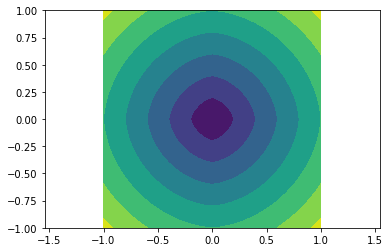

In [14]:
plt.axis('equal')
plt.contourf(X0,X1,solution);

Let us check that the system of equations is indeed solved.

In [15]:
residue = Scheme(solution,coefs,offsets,gridScale)
print("Max residue :",LInfNorm(residue))

Max residue : 1.7985612998927536e-14


### 2.2 Fast sweeping

In this approach, solution is updated slice after slice, left to right, right to left, top to bottom, bottom to top, etc. On large domains, the number of updates per pixel is smaller than with the global iteration approach.

In [16]:
def SweepSlices(shape):
    """Enumerates the slices used in the fast sweeping method."""
    dim = len(shape)
    s=(slice(None),)
    for d,n in enumerate(shape):
        for x in itertools.chain(range(n),reversed(range(n))):
            yield s*d +(x,)+s*(dim-d-1)

def SweepIteration(update,u0,args,eps=1e-6,niter_max=100):
    u=u0.copy()
    for niter in range(niter_max):
        u_old=u.copy()
        for sl in SweepSlices(u0.shape):
            u[sl]=update(u,*args,where=sl)
        if np.all(u+eps>=u_old):
            return u,niter*2*u0.ndim
    print("Iterative method did not reach stopping criterion within iteration budget")
    return u,niter_max*2*u0.ndim

**Note on execution time.** For some reason that needs to be clarified, the update of a slice of the domain costs almost as much as the update of the full domain with this Python implementation. (This is possibly an issue with memory management.) As a result, execution time is here much larger than with the global iteration approach. This effect is not encountered in reasonably optimized implementations, possibly written in other languages.

In [17]:
%%time
u0=np.where(np.isnan(bc),np.inf,bc)
solution,nupdate = SweepIteration(Update,u0,(coefs,offsets,gridScale))

CPU times: user 1.46 s, sys: 7.14 ms, total: 1.47 s
Wall time: 1.47 s


In principle, fast sweeping allows to substantially reduce the number of updates per point in comparison with global iteration. This effect is pronounced over large domains, but is not much observed in very small domains as here.

In [18]:
print("Average number of updates per point :", nupdate)

Average number of updates per point : 48


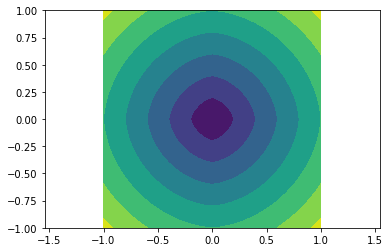

In [19]:
plt.axis('equal')
plt.contourf(X0,X1,solution);

In [20]:
residue = Scheme(solution,coefs,offsets,gridScale)
print("Max residue :",LInfNorm(residue))

Max residue : 1.7985612998927536e-14


### 2.3 Fast marching

The fast marching method updates the solution in a very specific order, in a Dijkstra-like fashion, taking advantage of the causality of the numerical scheme.

A preliminary step, achieved in the `ReverseNeighbors` routine, is to identify all the *reverse neighbors* of given point $y \in X$. In other words all $x \in X$ such that $y = x \pm h e_i(x)$ for some $1 \leq i \leq I$.

In [21]:
def ReverseNeighbors(shape,offsets):
    """Reverses a directed graph, defined by offsets on a cartesian grid. 
    The reverse neighbors for index i are orig[changes[i]:changes[i+1]], 
    where (orig,changes) is the output."""
    # Get original and neighbor offset
    neigh,inside = fd.OffsetToIndex(shape,offsets)
    size = np.prod(shape)
    orig = np.broadcast_to(np.arange(size),(neigh.size//size,size)).flatten()
    orig,neigh=orig[inside.flatten()],neigh[inside].flatten()

    # Sort according to neighbor offset
    ind = np.lexsort((orig,neigh))
    orig,neigh=orig[ind],neigh[ind]
    
    # Count
    changes = np.arange(1,neigh.size)[neigh[1:]!=neigh[:-1]]
    changes = np.append(np.insert(changes,0,0),neigh.size)
    return orig,changes

def FastMarching(update,u0,args):
    
    # Compute the reverse neighbors
    _,offsets,_ = args
    rev,chg = ReverseNeighbors(u0.shape,np.stack((offsets,-offsets),axis=1))

    # Find the seeds
    seeds = u0<np.inf
    heap=[(value,index) for value,index in zip(u0[seeds],np.arange(u0.size)[seeds.flatten()]) ]
    heapq.heapify(heap)
    
    # Run the Dijkstra-like method
    accepted = np.full(u0.shape,False).flatten()
    u = u0.copy().flatten()
    niter=0
    while heap:
        # Find the non-accepted point with smallest value
        value,index = heapq.heappop(heap)
        if value > u[index]: continue
        accepted[index]=True
        # Update the neighbors
        for index2 in rev[chg[index]:chg[index+1]]:
            if accepted[index2]: continue
            value2 = update(u.reshape(u0.shape),*args,where=np.unravel_index(index2,u0.shape))
            niter+=1
            if value2 < u[index2]:
                u[index2]=value2
                heapq.heappush(heap,(value2,index2))
    return u.reshape(u0.shape),niter/u0.size

**Note on execution time.** Again, the computation time observed here is not representative of what is obtained in a compiled language, compatible with sequential execution on a mutable state.

In [22]:
%%time
u0=np.where(np.isnan(bc),np.inf,bc)
solution,nupdate = FastMarching(Update,u0,(coefs,offsets,gridScale))

CPU times: user 4.21 s, sys: 11.7 ms, total: 4.22 s
Wall time: 4.22 s


The number of updates per point is greatly reduced w.r.t. the fast sweeping method (and global iteration as well). In some implementations, this can be counterbalanced by the cost of maintaining a priority queue.

In [23]:
print("Average number of updates per point :", nupdate)

Average number of updates per point : 2.9219530949634756


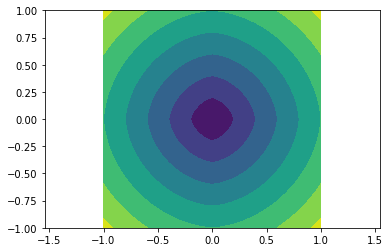

In [24]:
plt.axis('equal')
plt.contourf(X0,X1,solution);

Despite the smaller number of updates per point, the system is exactly solved.

In [25]:
residue = Scheme(solution,coefs,offsets,gridScale)
print("Max residue :",LInfNorm(residue))

Max residue : 1.7985612998927536e-14


## 3. Anisotropic metric

The numerical schemes above presented apply without modification to non-constant, anisotropic Riemannian metrics.

In [26]:
#Define the square [-1,1]^2, sampled on a cartesian grid
aX0 = np.linspace(-1,1,51); aX1 = aX0
gridScale=aX0[1]-aX0[0]
X0,X1 = np.meshgrid(aX0,aX1,indexing='ij')

# Generate the metric
eig1 = np.stack((np.full(X0.shape,1.),(np.pi/2)*np.cos(2*np.pi*X0)))
eig1 /= scipy.linalg.norm(eig1,axis=0) 
eig2 = np.stack( (eig1[1],-eig1[0]) ) # Rotate eig1 by pi/2
lambda1, lambda2 = 0.8, 0.2
metric = lambda1**-2*lp.outer_self(eig1) + lambda2**-2*lp.outer_self(eig2)

# Decompose the tensors dual to the Riemannian metric
coefs, offsets = Selling.Decomposition(lp.inverse(metric))
coefs[:,np.logical_not(np.isnan(bc))] = np.nan

In [27]:
%%time
u0=np.where(np.isnan(bc),np.inf,bc)
solution_Global,nupdate_Global = GlobalIteration(Update,u0,(coefs,offsets,gridScale))

CPU times: user 105 ms, sys: 4.15 ms, total: 109 ms
Wall time: 108 ms


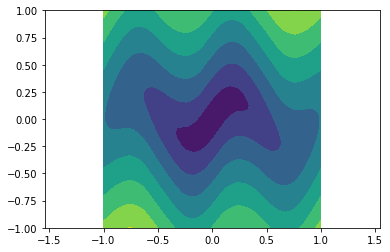

In [28]:
plt.axis('equal')
plt.contourf(X0,X1,solution_Global);

In [29]:
%%time
u0=np.where(np.isnan(bc),np.inf,bc)
solution_Sweep,nupdate_Sweep = SweepIteration(Update,u0,(coefs,offsets,gridScale))

CPU times: user 1.62 s, sys: 14.8 ms, total: 1.63 s
Wall time: 1.63 s


In [30]:
%%time
u0=np.where(np.isnan(bc),np.inf,bc)
solution_FM,nupdate_FM = FastMarching(Update,u0,(coefs,offsets,gridScale))

CPU times: user 4.93 s, sys: 36.7 ms, total: 4.97 s
Wall time: 4.98 s


As before, the number of updates per point is largest for global iteration, and smallest for the fast marching method.

In [31]:
print("Number of updates per point.")
print("Global iteration :",nupdate_Global)
print("Fast sweeping :",nupdate_Sweep)
print("Fast marching :",nupdate_FM)

Number of updates per point.
Global iteration : 65
Fast sweeping : 48
Fast marching : 3.021914648212226


The residue of the fast marching method is zero, up to numerical precision. In constrast, the residue of the fast sweeping method and of the global iteration method is expected to be of the order of the prescribed tolerance $\epsilon$, here defaulted to $\epsilon = 1e-6$.

In [32]:
residue_Global,residue_Sweep,residue_FM = (LInfNorm(Scheme(solution,coefs,offsets,gridScale))
                                           for solution in (solution_Global,solution_Sweep,solution_FM))
print("Numerical scheme residue.")
print("Global iteration :",residue_Global)
print("Fast sweeping :",residue_Sweep)
print("Fast marching :",residue_FM)

Numerical scheme residue.
Global iteration : 2.930180383664549e-06
Fast sweeping : 1.261707627264741e-09
Fast marching : 1.9761969838327786e-14
